Душкина Анастасия Алексеевна,
J4140

Лабораторная работа 2: Проектирование и реализация мультиагентной системы с использованием LangChain и LangGraph


Задание 1: Проектирование архитектуры

Описание системы

Разработана мультиагентная система для персонализированного подбора и работы с настольными играми. Система расширяет функциональность первой лабораторной работы, добавляя мультиагентную архитектуру с разделением ролей и интеллектуальной маршрутизацией запросов

Агенты системы

1. **Router Agent (Агент-роутер)** - классифицирует входящий запрос пользователя и определяет тип задачи:
* search - поиск игры по критериям
* explain - объяснение правил, механик, стратегий
* compare - сравнение нескольких игр
* plan - планирование игрового вечера
* general - общие вопросы о настольных играх

2. **Game Search Agent (Агент поиска игр)** - использует функции из лабы 1 для поиска игр:
* Парсит запрос пользователя в GameRecommendationPlan
* Использует filter_by_content и filter_by_metadata (параллельно)
* Выбирает лучшую игру из результатов
* Использует базу данных игр (mock_games или BGG)

3. **Game Theory Agent (Агент теории игр)** - объясняет:
* Правила настольных игр
* Механики и стратегии
* Сравнение игр
* Общие концепции настольных игр

4. **Planner Agent (Агент планирования)** - создает планы:
* Подбор игр для игрового вечера
* Последовательность игр для группы
* Учет предпочтений участников

5. **Memory Agent (Агент памяти)** - управляет памятью:
* Сохраняет предпочтения пользователя
* Запоминает историю поисков и рекомендаций
* Извлекает релевантную информацию из прошлых запросов

Паттерны МАС

Реализован паттерн **Router + Специализированные агенты**:
- Router анализирует запрос и направляет к соответствующему агенту
- Game Search Agent использует параллельную фильтрацию (content и metadata)
- Memory Agent работает параллельно, обновляя и извлекая информацию

Также используется **Planner-Executor паттерн**:
- Planner Agent создает план подбора игр
- Game Search Agent выполняет поиск по плану

Диаграмма потока управления

Визуализация графа будет отображена после создания графа в разделе "Пропишем сборку графа"

Tool Calling

Инструменты доступны агентам:
* filter_by_content - фильтрация игр по жанрам, темам, механикам
* filter_by_metadata - фильтрация по игрокам, времени, сложности
* select_best_game - выбор лучшей игры из списка
* load_games - загрузка игр из базы данных
* save_to_memory - сохранение предпочтений пользователя
* get_from_memory - извлечение истории поисков

Управление памятью

Память организована в состоянии графа:
* session_history - история запросов и рекомендаций в текущей сессии
* user_preferences - предпочтения пользователя (любимые жанры, механики, сложность)
* recommendation_history - история рекомендованных игр
* knowledge_base - база знаний о играх и их особенностях

Memory Agent:
* Автоматически обновляет session_history после каждого взаимодействия
* Сохраняет предпочтения пользователя на основе истории
* Извлекает релевантную информацию при обработке новых запросов

Задание 2: Реализация в LangGraph + LangChain

Установка зависимостей


In [1]:
# !pip install langchain langchain-openai langgraph langchain-core python-dotenv pydantic>=2.0

Импорт библиотек


In [2]:
import os
import json
import time
from datetime import datetime, timedelta
from typing import TypedDict, List, Optional, Literal
from pydantic import BaseModel, Field
from dotenv import load_dotenv, find_dotenv

from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser, JsonOutputParser
from langchain_core.messages import SystemMessage, HumanMessage
from langchain_core.exceptions import OutputParserException
from langgraph.graph import StateGraph, START, END


Настройка подключения к модели

Плюс проверим как отвечает система (пример из practice_mas)


In [3]:
if not os.getenv("OPENAI_API_KEY"):
    os.environ["OPENAI_API_KEY"] = "sk-teacher-key-123-litellm"

MODEL_NAME = os.getenv("OPENAI_MODEL_NAME", "qwen3-32b")
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
OPENAI_API_BASE = os.getenv("OPENAI_API_BASE", "http://10.32.15.89:34000/v1")

llm = ChatOpenAI(
    model=MODEL_NAME,
    openai_api_key=OPENAI_API_KEY,
    openai_api_base=OPENAI_API_BASE,
    temperature=0.4,
)

print("Model:", MODEL_NAME)
print("Base:", OPENAI_API_BASE)

response = llm.invoke([HumanMessage(content="Поприветствуй от лица одинокого волка-агента.")])
print("LLM says:", response.content[:200])

Model: qwen3-32b
Base: http://10.32.15.89:34000/v1
LLM says: 

**Приветствие от одинокого волка-агента:**  

«Ночь шепчет свои тайны, а я — её тень. Зови меня *Серым*. Я слежу за горизонтом, где мечты соприкасаются с реальностью. Если твой путь привёл сюда — не


Определим схемы данных которые будут описывать сущности и сообщения в системе рекомендаций настольных игр. Сначала задаем класс Game который содержит всю основную информацию об игре: название, сколько игроков нужно, сколько времени занимает партия, минимальный возраст, уровень сложности, списки жанров, тем и механик, плюс описание и характеристики взаимодействия и языковой зависимости 

Задаем класс GameRecommendationPlan, он описывает критерии по которым пользователь хочет получить рекомендацию: сколько будет игроков, сколько времени у них есть, какие жанры или механики интересны, насколько сложную игру они готовы освоить и какие еще предпочтения у них есть по взаимодействию и языку

Класс FilteredGamesResult просто объединяет список подходящих игр после фильтрации. GameRecommendationResponse содержит конкретную рекомендованную игру и текстовое объяснение, почему именно она подходит 

RoutingDecision используется для принятия решения о том какой агент должен обработать запрос пользователя, например, агент поиска, объяснения, сравнения и так далее вместе с обоснованием этого выбора и указанием нужно ли обращаться к памяти или строить план действий

AgentResponse представляет собой обобщенный ответ любого агента: в нем есть основной текст ответа, список рекомендованных игр, перечень использованных инструментов, при необходимости информация о том что следует сохранить или обновить в памяти системы. Все вместе формирует типизированную и структурированную основу для работы мультиагентной рекомендательной системы

In [4]:
class Game(BaseModel):
    name: str
    players_min: int
    players_max: int
    duration_min: int
    duration_max: int   
    min_age: int
    complexity: float
    genres: List[str]
    themes: List[str]
    mechanics: List[str]
    interaction: str
    language_dependence: str
    description: str

class GameRecommendationPlan(BaseModel):
    num_players: int = Field(..., description = "Точное количество игроков")
    min_age: int = Field(default = 10, description = "Минимальный возраст (по умолчанию 10)")
    max_duration_minutes: int = Field(..., description = "Максимальная длительность партии в минутах")
    genre_keywords: List[str] = Field(default_factory = list, description = "Жанры")
    themes: List[str] = Field(default_factory = list, description = "Тематики")
    mechanics: List[str] = Field(default_factory = list, description = "Механики")
    max_complexity: float = Field(default = 5.0, ge = 1.0, le = 5.0, description = "Максимальная сложность")
    interaction_level: str = Field(default = "any", description = "Уровень взаимодействия")
    language_dependence: str = Field(default = "any", description = "Языковая зависимость")

class FilteredGamesResult(BaseModel):
    games: List[Game]

class GameRecommendationResponse(BaseModel):
    recommended_game: Game
    reasoning: str

class RoutingDecision(BaseModel):
    """Решение роутера о маршрутизации запроса"""
    agent_type: Literal["search", "explain", "compare", "plan", "general"] = Field(
        description="Тип агента для обработки запроса"
    )
    reason: str = Field(description = "Объяснение выбора агента")
    needs_memory: bool = Field(default = True, description = "Нужно ли извлекать информацию из памяти")
    needs_planning: bool = Field(default = False, description = "Нужно ли создавать план действий")

class AgentResponse(BaseModel):
    """Ответ агента пользователю"""
    answer: str = Field(description = "Основной ответ")
    recommended_games: List[Game] = Field(default_factory = list, description = "Рекомендованные игры")
    used_tools: List[str] = Field(default_factory = list, description = "Список использованных инструментов")
    memory_updates: Optional[str] = Field(default = None, description = "Что нужно обновить в памяти")

Определение состояния графа

В нем хранится вся необходимая информация которая может понадобиться во время обработки запроса пользователя. Сюда входит сам запрос и идентификатор пользователя если он есть. Также сохраняются промежуточные результаты работы системы: решение о том какой агент должен обработать запрос, план рекомендации, игры и итоговый список подходящих игр. После выполнения задачи здесь же фиксируется ответ агента

In [5]:
class SystemState(TypedDict):
    """Состояние мультиагентной системы"""
    user_query: str
    user_id: Optional[str]
    
    routing_decision: Optional[RoutingDecision]
    recommendation_plan: Optional[GameRecommendationPlan]
    content_filtered: List[Game]
    metadata_filtered: List[Game]
    final_games: List[Game]
    agent_response: Optional[AgentResponse]

    session_history: List[dict]
    user_preferences: dict
    recommendation_history: List[Game]
    knowledge_base: dict 

    final_answer: str
    execution_path: List[str]

Реализация инструментов (Tools)

Из лабы 1 возьмем функцию которая возвращает некоторый вручную прописанный список популярных игр и каждая из них показывает разные аспекты настольных игр: от тихой евростратегии с низким взаимодействием «Каскадия» до асимметричной войны с высокой сложностью и языковой зависимостью «Корни»

Также загрузимв базу данных игр из внешнего источника. Определим функцию фильтрации по содержанию которая проверяет содержит ли игра хотя бы одно из указанных пользователем ключевых слов в жанрах, темах или механиках, и оставляет только подходящие. Функцию которая фильтрует игры по метаданным: она учитывает количество игроков, минимальный возраст, максимальную длительность партии, допустимую сложность, уровень взаимодействия и языковую зависимость, отбрасывая те игры, которые не соответствуют хотя бы одному из этих условий. Функцию которая выбирает из оставшихся игр одну лучшую

In [6]:
def load_mock_games() -> List[Game]:
    """Загружает список популярных настольных игр (из ЛР1)"""
    return [
        Game(
            name="Каскадия",
            players_min=1, players_max=4,
            duration_min=30, duration_max=60,
            min_age=14,
            complexity=2.3,
            genres=["евростратегия"],
            themes=["природа", "животные"],
            mechanics=["драфт", "кубики", "тайл-placement"],
            interaction="низкая",
            language_dependence="низкая",
            description="Стратегия с драфтом карт и кубиками — сочетание планирования и удачного драфта"
        ),
        Game(
            name="Азул",
            players_min=2, players_max=4,
            duration_min=30, duration_max=45,
            min_age=8,
            complexity=2.0,
            genres=["абстрактная стратегия"],
            themes=["абстракция", "искусство"],
            mechanics=["тайл-placement", "сет-collection"],
            interaction="средняя",    
            language_dependence="низкая",
            description="Элегантная игра на размещение плиток с элементами планирования"
        ),
        Game(
            name="Пандемия",
            players_min=2, players_max=4,
            duration_min=45, duration_max=60,
            min_age=8,
            complexity=2.4,
            genres=["кооператив"],
            themes=["наука", "болезни"],
            mechanics=["кооператив", "драфт"],
            interaction="высокая",
            language_dependence="средняя",
            description="Командная борьба с глобальными эпидемиями. Требует общения"
        ),
        Game(
            name="Корни (Root)",
            players_min=2, players_max=4,
            duration_min=60, duration_max=90,
            min_age=12,
            complexity=4.2,
            genres=["асимметричная стратегия", "война"],
            themes=["лес", "животные", "фэнтези"],
            mechanics=["карточки", "кубики", "area control"],
            interaction="высокая",
            language_dependence="высокая",
            description="Глубокая стратегия с конфликтом и уникальными фракциями"
        ),
        Game(
            name="Уютная усадьба",
            players_min=1, players_max=4,
            duration_min=30, duration_max=60,
            min_age=12,
            complexity=2.5,
            genres=["евростратегия", "семейная"],
            themes=["фэнтези", "строительство", "управление"],
            mechanics=["тайл-placement", "сет-collection", "менеджмент ресурсов"],
            interaction="низкая",
            language_dependence="низкая",
            description="Спокойная игра на строительство усадьбы в волшебном мире"
        ),
        Game(
            name="Доббль",
            players_min=2, players_max=8,
            duration_min=15, duration_max=30,
            min_age=6,
            complexity=1.2,
            genres=["вечеринка", "реакция"],
            themes=["абстракция", "карточки"],
            mechanics=["поиск совпадений", "реальное время"],
            interaction="высокая",
            language_dependence="низкая",
            description="Быстрая игра на внимательность: найди одинаковый символ на двух картах"
        ),
        Game(
            name="Колонизаторы",
            players_min=3, players_max=4,
            duration_min=60, duration_max=120,
            min_age=10,
            complexity=3.2,
            genres=["евростратегия", "торговля"],
            themes=["колонизация", "экономика", "история"],
            mechanics=["торговля", "ролевые карты", "сет-collection"],
            interaction="средняя",
            language_dependence="средняя",
            description="Классика на развитие поселений, торговлю и строительство"
        ),
        Game(
            name="Кодовые имена",
            players_min=4, players_max=8,
            duration_min=15, duration_max=30,
            min_age=10,
            complexity=1.8,
            genres=["вечеринка", "словесная"],
            themes=["шпионаж", "слова"],
            mechanics=["ассоциации", "командная игра", "скрытая информация"],
            interaction="высокая",
            language_dependence="высокая",
            description="Командная игра на ассоциации: веди свою команду к победе через одно слово"
        ),
        Game(
            name="Ужас Аркхэма",
            players_min=1, players_max=8,
            duration_min=120, duration_max=180,
            min_age=14,
            complexity=4.0,
            genres=["кооператив", "приключение", "ролевая система"],
            themes=["ужасы", "Лавкрафт", "расследование"],
            mechanics=["кооператив", "броски кубиков", "сюжетные сценарии"],
            interaction="высокая",
            language_dependence="высокая",
            description="Эпическое кооперативное приключение против древних богов. Требует командной работы и чтения"
        ),
        Game(
            name="7 чудес",
            players_min=2, players_max=7,
            duration_min=30, duration_max=60,
            min_age=10,
            complexity=2.6,
            genres=["карточная стратегия", "цивилизация"],
            themes=["античность", "история", "строительство"],
            mechanics=["карточный драфт", "сет-collection", "милитария"],
            interaction="средняя",
            language_dependence="низкая",
            description="Стройте древние цивилизации через карточный драфт. Быстро, масштабно, для большой компании"
        ),
        Game(
            name="Манчкин",
            players_min=3, players_max=6,
            duration_min=60, duration_max=120,
            min_age=10,
            complexity=2.2,
            genres=["вечеринка", "фэнтези"],
            themes=["фэнтези", "юмор", "ролевая игра"],
            mechanics=["карточки", "блюфф", "прямой конфликт"],
            interaction="высокая",
            language_dependence="высокая",
            description="Юмористическая карточная игра о подземельях, монстрах и предательствах"
        ),
        Game(
            name="Вингспан",
            players_min=1, players_max=5,
            duration_min=40, duration_max=70,
            min_age=10,
            complexity=2.9,
            genres=["евростратегия", "коллекционирование"],
            themes=["природа", "птицы", "наука"],
            mechanics=["двигатели", "тайл-placement", "менеджмент ресурсов"],
            interaction="низкая",
            language_dependence="средняя",
            description="Спокойная стратегия о создании заповедника для птиц. Красиво и познавательно"
        ),
    ]

GAMES_DATABASE = load_mock_games()

def filter_by_content(plan: GameRecommendationPlan) -> FilteredGamesResult:
    """Фильтрация игр по жанрам, темам и механикам"""
    matched = []
    for g in GAMES_DATABASE:
        if plan.genre_keywords and not any(kw.lower() in " ".join(g.genres).lower() for kw in plan.genre_keywords):
            continue
        if plan.themes and not any(t.lower() in " ".join(g.themes).lower() for t in plan.themes):
            continue
        if plan.mechanics and not any(m.lower() in " ".join(g.mechanics).lower() for m in plan.mechanics):
            continue
        matched.append(g)
    return FilteredGamesResult(games=matched)

def filter_by_metadata(plan: GameRecommendationPlan) -> FilteredGamesResult:
    """Фильтрация игр по метаданным"""
    matched = []
    for g in GAMES_DATABASE:
        if not (g.players_min <= plan.num_players <= g.players_max):
            continue
        if g.min_age > plan.min_age:
            continue
        if g.duration_max > plan.max_duration_minutes:
            continue
        if g.complexity > plan.max_complexity:
            continue
        if plan.interaction_level != "any" and g.interaction != plan.interaction_level:
            continue
        if plan.language_dependence != "any" and g.language_dependence != plan.language_dependence:
            continue
        matched.append(g)
    return FilteredGamesResult(games=matched)

def select_best_game(games: List[Game]) -> Optional[Game]:
    """Выбор лучшей игры из списка"""
    if not games:
        return None
    return max(games, key=lambda g: (
        -(abs(g.players_max - g.players_min)), 
        -abs((g.duration_min + g.duration_max) / 2 - 45),  
        -g.complexity  
    ))

def safe_filter_with_retry(func, plan, max_retries=2):
    """Безопасная фильтрация с повторными попытками"""
    for _ in range(max_retries + 1):
        try:
            return func(plan).games
        except Exception:
            continue
    return []

Реализация узлов графа

Прописываем Router Node

Это узел роутера в мультиагентной системе для обработки запросов о настольных играх. Роутер анализирует текст запроса пользователя и учитывает последние три сообщения из истории сессии чтобы решить какой специализированный агент должен заняться обработкой: поиском игр, объяснением правил, сравнением, планированием игрового вечера или ответом на общие вопросы. Для этого используем шаблон системного промпта который описывает назначение каждого типа агента и требует ответ в строгом JSON-формате соответствующем структуре RoutingDecision. Промпт передается языковой модели через цепочку которая включает парсер для преобразования результата в валидный объект

In [7]:
router_prompt = ChatPromptTemplate.from_messages([
    ("system", """
Вы - роутер запросов в мультиагентной системе для работы с настольными играми

Ваша задача - проанализировать запрос пользователя и определить, какой специализированный агент должен его обработать:

- "search" - для поиска игр по критериям (количество игроков, время, жанр, механики и т.д.)
- "explain" - для объяснения правил, механик, стратегий конкретных игр
- "compare" - для сравнения нескольких игр между собой
- "plan" - для планирования игрового вечера, подбора игр для группы
- "general" - для общих вопросов о настольных играх

Также определите:
- needs_memory: нужно ли извлекать информацию из истории сессии или предпочтений пользователя (true/false)
- needs_planning: нужно ли создавать пошаговый план действий (true/false)

Отвечайте строго в формате JSON: {{"agent_type": "search" или "explain" или "compare" или "plan" или "general", "reason": "объяснение", "needs_memory": true/false, "needs_planning": true/false}}
"""),
    ("human", """
Запрос пользователя: {query}

История сессии (последние 3 сообщения):
{history}
""")
])

json_parser = JsonOutputParser(pydantic_object=RoutingDecision)
router_chain = router_prompt | llm | StrOutputParser() | json_parser

def router_node(state: SystemState) -> dict:
    """Узел роутера: классифицирует запрос и определяет маршрут"""
    query = state.get("user_query", "")
    history = state.get("session_history", [])

    history_text = ""
    if history:
        recent = history[-3:]
        history_text = "\n".join([
            f"Q: {h.get('query', '')}\nA: {h.get('answer', '')[:100]}..."
            for h in recent
        ])
    else:
        history_text = "История пуста"
    
    try:
        decision_dict = router_chain.invoke({
            "query": query,
            "history": history_text
        })
        
        if isinstance(decision_dict, dict):
            decision = RoutingDecision(**decision_dict)
        else:
            decision = decision_dict
        
        execution_path = state.get("execution_path", [])
        execution_path.append(f"router -> {decision.agent_type}")
        
        return {
            "routing_decision": decision,
            "execution_path": execution_path
        }
    except Exception as e:
        print(f"[Router] Error parsing decision: {e}")
        print("[Router] Using fallback: checking keywords...")
        query_lower = query.lower()
        if any(kw in query_lower for kw in ["найди", "порекомендуй", "подбери", "игра для", "игрок", "минут", "жанр"]):
            agent_type = "search"
        elif any(kw in query_lower for kw in ["объясни", "правила", "как играть", "механик", "стратеги"]):
            agent_type = "explain"
        elif any(kw in query_lower for kw in ["сравни", "разница", "лучше", "чем отличается"]):
            agent_type = "compare"
        elif any(kw in query_lower for kw in ["план", "вечер", "подобрать игры", "последовательность"]):
            agent_type = "plan"
        else:
            agent_type = "general"
        
        decision = RoutingDecision(
            agent_type=agent_type,
            reason=f"Fallback: detected keywords for {agent_type}",
            needs_memory=True,
            needs_planning=False
        )
        
        execution_path = state.get("execution_path", [])
        execution_path.append(f"router -> {agent_type} (fallback)")
        
        return {
            "routing_decision": decision,
            "execution_path": execution_path
        }

Прописываем Memory Node

Это узел памяти в мультиагентной системе который отвечает за извлечение релевантной информации из истории взаимодействий и базы знаний для текущего запроса пользователя. Если решение роутера указывает что для запроса требуется доступ к памяти узел анализирует текст запроса: разбивает его на слова и ищет схожие фразы в последних десяти записях истории сессии считая совпадение как минимум двух слов признаком релевантности. Параллельно он просматривает базу знаний и отбирает ключи или значения содержащие хотя бы одно слово из запроса. Найденные фрагменты истории и знаний объединяются в краткий текстовый контекст который можно использовать на следующих этапах обработки

In [8]:
def memory_node(state: SystemState) -> dict:
    """Узел памяти: извлекает релевантную информацию из истории и базы знаний"""
    query = state.get("user_query", "")
    routing_decision = state.get("routing_decision")
    session_history = state.get("session_history", [])
    knowledge_base = state.get("knowledge_base", {})
    user_profile = state.get("user_profile", {})
    
    relevant_context = []
    
    if routing_decision and routing_decision.needs_memory:
        query_lower = query.lower()
        query_words = set(query_lower.split())
        
        for entry in session_history[-10:]:
            entry_query = entry.get("query", "").lower()
            entry_words = set(entry_query.split())
            if len(query_words & entry_words) >= 2:
                relevant_context.append({
                    "type": "history",
                    "query": entry.get("query", ""),
                    "answer": entry.get("answer", "")[:200]
                })

        for key, value in knowledge_base.items():
            if any(word in key.lower() or word in str(value).lower() for word in query_words):
                relevant_context.append({
                    "type": "knowledge",
                    "key": key,
                    "value": str(value)
                })

    context_text = ""
    if relevant_context:
        context_text = "Релевантная информация из памяти:\n"
        for ctx in relevant_context[:5]:
            if ctx["type"] == "history":
                context_text += f"- Предыдущий вопрос: {ctx['query']}\n  Ответ: {ctx['answer']}\n"
            else:
                context_text += f"- {ctx['key']}: {ctx['value']}\n"
    else:
        context_text = "Релевантной информации в памяти не найдено"

    return {
        "knowledge_base": knowledge_base,
        "user_profile": user_profile 
    }

Прописываем Planner Node

Это узел планировщика который преобразует неструктурированный текстовый запрос пользователя в строго заданную структуру параметров поиска игр, объект типа GameRecommendationPlan. Для этого он формирует системное сообщение с инструкциями для языковой модели: как определять возраст, какие механики или жанры добавлять при наличии ключевых слов и в каком формате возвращать результат. Запрос пользователя передается модели вместе с этими инструкциями и система пытается извлечь из ее ответа корректный JSON

In [9]:
def planner_node(state: SystemState) -> dict:
    """Узел планировщика: парсит запрос пользователя в GameRecommendationPlan"""
    query = state.get("user_query", "")
    
    messages = [
        SystemMessage(
            content=(
                "Вы — эксперт по настольным играм. Ваша задача — извлечь из запроса пользователя параметры для поиска игр и преобразовать их в строго структурированный JSON.\n\n"
                "Правила:\n"
                "1. Если возраст не указан, установите min_age=14, если в запросе есть слова \"стратегия\", \"тактика\" или \"план\"; иначе min_age = 10.\n"
                "2. Если упомянуты \"азарт\", \"удача\", \"риск\" — добавьте в mechanics: [\"кубики\", \"карточки\"].\n"
                "3. Если упомянута \"стратегия\" — добавьте в genre_keywords: [\"стратегия\"].\n"
                "4. max_complexity ДОЛЖНО быть числом от 1.0 до 5.0 (включительно). Если не указано, используйте 3.0.\n"
                "5. num_players ДОЛЖНО быть положительным целым числом (>= 1).\n"
                "6. max_duration_minutes ДОЛЖНО быть положительным целым числом (>= 1).\n"
                "7. Используйте ТОЛЬКО поля, определённые в схеме.\n"
                "8. Верните ТОЛЬКО валидный JSON, без пояснений.\n\n"
                "Формат JSON: {{\"num_players\": число >= 1, \"min_age\": число >= 0, \"max_duration_minutes\": число >= 1, \"genre_keywords\": [\"...\"], \"themes\": [\"...\"], \"mechanics\": [\"...\"], \"max_complexity\": число от 1.0 до 5.0, \"interaction_level\": \"any\" или \"низкая\" или \"средняя\" или \"высокая\" или \"кооператив\", \"language_dependence\": \"any\" или \"низкая\" или \"средняя\" или \"высокая\"}}"
            )
        ),
        HumanMessage(content=f"Запрос пользователя: {query}")
    ]
    
    max_retries = 3
    for attempt in range(max_retries):
        try:
            resp = llm.invoke(messages)
            content = resp.content

            import re
            json_match = re.search(r'\{.*\}', content, re.DOTALL)
            if json_match:
                plan_dict = json.loads(json_match.group())
            else:
                plan_dict = json.loads(content)
            
            if "max_complexity" in plan_dict:
                max_comp = plan_dict["max_complexity"]
                if isinstance(max_comp, (int, float)):
                    if max_comp < 1.0:
                        plan_dict["max_complexity"] = 3.0 
                    elif max_comp > 5.0:
                        plan_dict["max_complexity"] = 5.0
                else:
                    plan_dict["max_complexity"] = 3.0
            else:
                plan_dict["max_complexity"] = 3.0

            if "num_players" in plan_dict:
                if not isinstance(plan_dict["num_players"], int) or plan_dict["num_players"] <= 0:
                    plan_dict["num_players"] = 2
            else:
                plan_dict["num_players"] = 2

            if "max_duration_minutes" in plan_dict:
                if not isinstance(plan_dict["max_duration_minutes"], int) or plan_dict["max_duration_minutes"] <= 0:
                    plan_dict["max_duration_minutes"] = 60
            else:
                plan_dict["max_duration_minutes"] = 60

            if "min_age" in plan_dict:
                if not isinstance(plan_dict["min_age"], int) or plan_dict["min_age"] < 0:
                    plan_dict["min_age"] = 10
            else:
                plan_dict["min_age"] = 10

            if "genre_keywords" not in plan_dict or not isinstance(plan_dict["genre_keywords"], list):
                plan_dict["genre_keywords"] = []
            if "themes" not in plan_dict or not isinstance(plan_dict["themes"], list):
                plan_dict["themes"] = []
            if "mechanics" not in plan_dict or not isinstance(plan_dict["mechanics"], list):
                plan_dict["mechanics"] = []

            if "interaction_level" not in plan_dict:
                plan_dict["interaction_level"] = "any"
            if "language_dependence" not in plan_dict:
                plan_dict["language_dependence"] = "any"
            
            plan = GameRecommendationPlan(**plan_dict)
            
            execution_path = state.get("execution_path", [])
            execution_path.append("planner")
            
            return {
                "recommendation_plan": plan,
                "execution_path": execution_path
            }
        except Exception as e:
            if attempt == max_retries - 1:
                print(f"Ошибка планировщика: {e}")
                plan = GameRecommendationPlan(
                    num_players = 4,
                    min_age = 14,
                    max_duration_minutes = 60,
                    genre_keywords = ["стратегия"],
                    themes = [],
                    mechanics = [],
                    max_complexity = 3.0, 
                    interaction_level = "any",
                    language_dependence = "any"
                )
                
                execution_path = state.get("execution_path", [])
                execution_path.append("planner (fallback)")
                
                return {
                    "recommendation_plan": plan,
                    "execution_path": execution_path
                }
            time.sleep(0.5)

    plan = GameRecommendationPlan(
        num_players = 2, 
        min_age = 10, 
        max_duration_minutes = 60, 
        max_complexity = 3.0,
        genre_keywords = [],
        themes = [],
        mechanics = [],
        interaction_level = "any",
        language_dependence = "any"
    )
    return {"recommendation_plan": plan, "execution_path": state.get("execution_path", [])}

Пропишем Content Filter Node и Metadata Filter Node - было в лабе 1

Это три последовательных узла отвечающих за фильтрацию и объединение результатов при поиске подходящих настольных игр. Первый узел content_filter_node, он получает из состояния системы план рекомендации и если он существует применяет к базе игр фильтрацию по содержательным характеристикам: жанрам, темам и механикам используя ранее определенную функцию с механизмом повторных попыток на случай ошибок. Второй узел metadata_filter_node, он делает то же самое, но фильтрует игры по метаданным: количеству игроков, длительности, возрастному ограничению, сложности и другим числовым или категориальным параметрам. Третий узел merge_results_node, он объединяет результаты двух фильтров оставляя только те игры которые прошли обе проверки: для этого он строит множества названий игр из каждого списка, находит их пересечение и затем восстанавливает полные объекты игр из исходной базы данных по этим названиям чтобы сохранить все исходные данные

In [10]:
def content_filter_node(state: SystemState) -> dict:
    """Фильтрация игр по контенту (жанры, темы, механики)"""
    plan = state.get("recommendation_plan")
    if not plan:
        return {"content_filtered": []}
    return {"content_filtered": safe_filter_with_retry(filter_by_content, plan)}

def metadata_filter_node(state: SystemState) -> dict:
    """Фильтрация игр по метаданным (игроки, время, сложность)"""
    plan = state.get("recommendation_plan")
    if not plan:
        return {"metadata_filtered": []}
    return {"metadata_filtered": safe_filter_with_retry(filter_by_metadata, plan)}

def merge_results_node(state: SystemState) -> dict:
    """Объединение результатов фильтрации"""
    set1 = {g.name for g in state.get("content_filtered", [])}
    set2 = {g.name for g in state.get("metadata_filtered", [])}
    common = set1 & set2
    final = [g for g in GAMES_DATABASE if g.name in common]
    return {"final_games": final}

Пропишем Game Search Node

Это узел поиска игр который завершает процесс рекомендации: он получает список игр прошедших обе стадии фильтрации и выбирает из них одну наилучшую используя ранее определенную функцию выбора. Если подходящих игр нет он формирует ответ о том что ничего не найдено и предлагает изменить критерии

In [11]:
def game_search_node(state: SystemState) -> dict:
    """Узел поиска игр: выбирает лучшую игру из отфильтрованных результатов"""
    final_games = state.get("final_games", [])
    recommendation_plan = state.get("recommendation_plan")
    
    if not final_games:
        response = AgentResponse(
            answer = "К сожалению, не найдено игр, соответствующих вашим критериям. Попробуйте изменить параметры поиска",
            recommended_games = [],
            used_tools = ["filter_by_content", "filter_by_metadata", "select_best_game"],
            memory_updates = None
        )
    else:
        best_game = select_best_game(final_games)
        if best_game:
            reasoning = f"Игра '{best_game.name}' выбрана как оптимальная по критериям: "
            reasoning += f"подходит для {best_game.players_min}-{best_game.players_max} игроков, "
            reasoning += f"длительность {best_game.duration_min}-{best_game.duration_max} минут, "
            reasoning += f"сложность {best_game.complexity}/5.0"
            
            response = AgentResponse(
                answer = f"Рекомендую игру: {best_game.name}\n\n{best_game.description}\n\n{reasoning}",
                recommended_games = [best_game],
                used_tools = ["filter_by_content", "filter_by_metadata", "select_best_game"],
                memory_updates = None
            )
        else:
            response = AgentResponse(
                answer = "Не удалось выбрать лучшую игру из найденных",
                recommended_games = [],
                used_tools = ["filter_by_content", "filter_by_metadata"],
                memory_updates = None
            )
    
    execution_path = state.get("execution_path", [])
    execution_path.append("game_search")
    
    return {
        "agent_response": response,
        "execution_path": execution_path
    }

Пропишем Theory Node

Это узел теории, компонент системы предназначенный для ответа на теоретические, объяснительные или учебные вопросы пользователя. Он получает текущий запрос и при необходимости извлекает контекст из последних 3х записей истории сессии и если существует добавляет информацию о плане действий

In [12]:
def theory_node(state: SystemState) -> dict:
    """Узел теории: отвечает на теоретические вопросы"""
    query = state.get("user_query", "")
    action_plan = state.get("action_plan")
    session_history = state.get("session_history", [])
    
    memory_context = ""
    if session_history:
        recent = session_history[-3:]
        memory_context = "\n".join([
            f"Q: {h.get('query', '')}\nA: {h.get('answer', '')[:100]}"
            for h in recent
        ])
    
    plan_text = ""
    if action_plan:
        plan_text = f"Цель: {action_plan.goal}\nШаги: {'; '.join(action_plan.steps)}"

    used_tools = []
    if any(op in query for op in ["+", "-", "*", "/", "=", "вычисл", "посчитай"]):
        used_tools.append("calculator")
    
    messages = [
        SystemMessage(
            content=(
                "Вы - агент-теоретик, специализирующийся на объяснении концепций, теории и учебных материалов\n\n"
                "Ваша задача:\n"
                "- Давать четкие и понятные объяснения\n"
                "- Использовать примеры для иллюстрации\n"
                "- Ссылаться на релевантную информацию из истории, если она есть\n\n"
                "Отвечайте подробно и структурированно"
            )
        ),
        HumanMessage(
            content=(
                f"Запрос пользователя: {query}\n\n"
                f"Контекст из памяти:\n{memory_context if memory_context else 'Контекста нет'}\n\n"
                f"План действий (если есть):\n{plan_text if plan_text else 'Плана нет'}"
            )
        ),
    ]
    
    try:
        resp = llm.invoke(messages)
        answer = resp.content
        
        response = AgentResponse(
            answer = answer,
            used_tools = used_tools,
            memory_updates = None
        )
        
        execution_path = state.get("execution_path", [])
        execution_path.append("theory")
        
        return {
            "agent_response": response,
            "execution_path": execution_path
        }
    except Exception as e:
        print(f"Ошибка theory агента: {e}")
        response = AgentResponse(
            answer = f"Теоретический ответ на вопрос: {query}. (Fallback режим)",
            used_tools = [],
            memory_updates = None
        )
        
        execution_path = state.get("execution_path", [])
        execution_path.append("theory (fallback)")
        
        return {
            "agent_response": response,
            "execution_path": execution_path
        }

Пропишем Code Node

Это узел отвечающий за помощь в программировании. Он принимает текущий запрос пользователя и добавляет контекст из последних трех сообщений истории сессии и информацию о плане действий. На основе этого формируется промпт для языковой модели с инструкцией: агент должен объяснять код, исправлять ошибки, предлагать решения задач, описывать алгоритмы и структуры данных, сопровождать ответы примерами кода. Модель вызывается с этим промптом и ее ответ упаковывается в стандартный объект AgentResponse

In [13]:
def code_node(state: SystemState) -> dict:
    """Узел кода: помогает с программированием"""
    query = state.get("user_query", "")
    action_plan = state.get("action_plan")
    session_history = state.get("session_history", [])

    memory_context = ""
    if session_history:
        recent = session_history[-3:]
        memory_context = "\n".join([
            f"Q: {h.get('query', '')}\nA: {h.get('answer', '')[:100]}"
            for h in recent
        ])
    
    plan_text = ""
    if action_plan:
        plan_text = f"Цель: {action_plan.goal}\nШаги: {'; '.join(action_plan.steps)}"
    
    messages = [
        SystemMessage(
            content = (
                "Вы - агент-программист, специализирующийся на помощи с кодом, алгоритмами и программированием\n\n"
                "Ваша задача:\n"
                "- Объяснять код и ошибки\n"
                "- Предлагать решения проблем\n"
                "- Помогать с алгоритмами и структурами данных\n"
                "- Использовать примеры кода для иллюстрации\n\n"
                "Отвечайте подробно с примерами кода"
            )
        ),
        HumanMessage(
            content = (
                f"Запрос пользователя: {query}\n\n"
                f"Контекст из памяти:\n{memory_context if memory_context else 'Контекста нет'}\n\n"
                f"План действий (если есть):\n{plan_text if plan_text else 'Плана нет'}"
            )
        ),
    ]
    
    try:
        resp = llm.invoke(messages)
        answer = resp.content
        
        response = AgentResponse(
            answer = answer,
            used_tools = [],
            memory_updates = None
        )
        
        execution_path = state.get("execution_path", [])
        execution_path.append("code")
        
        return {
            "agent_response": response,
            "execution_path": execution_path
        }
    except Exception as e:
        print(f"Ошибка code агента: {e}")
        response = AgentResponse(
            answer = f"Ответ по программированию на вопрос: {query}. (Fallback режим)",
            used_tools = [],
            memory_updates=  None
        )
        
        execution_path = state.get("execution_path", [])
        execution_path.append("code (fallback)")
        
        return {
            "agent_response": response,
            "execution_path": execution_path
        }

Пропишем Update Memory Node

Это узел обновления памяти который сохраняет информацию о завершенном взаимодействии для использования в будущих запросах. Он берет текущий запрос пользователя, полученный от агента ответ, решение роутера о типе агента и существующую историю сессии, формирует новую запись содержащую текст запроса, ответ, тип обработавшего агента и точную временную метку и добавляет ее в историю

In [14]:
def update_memory_node(state: SystemState) -> dict:
    """Обновляет память системы после получения ответа"""
    query = state.get("user_query", "")
    agent_response = state.get("agent_response")
    routing_decision = state.get("routing_decision")
    session_history = state.get("session_history", [])
    knowledge_base = state.get("knowledge_base", {})
    
    new_entry = {
        "query": query,
        "answer": agent_response.answer if agent_response else "",
        "agent": routing_decision.agent_type if routing_decision else "unknown",
        "timestamp": datetime.now().isoformat()
    }
    session_history.append(new_entry)

    if agent_response and agent_response.memory_updates:
        key = f"topic_{len(knowledge_base)}"
        knowledge_base[key] = agent_response.memory_updates
    
    return {
        "session_history": session_history,
        "knowledge_base": knowledge_base
    }

Пропишем Final Response Node

Это узел формирования окончательного ответа который подготавливает финальное сообщение для пользователя на основе данных собранных системой. Он берет ответ сгенерированный соответствующим агентом и использует его как основу финального текста

In [15]:
def final_response_node(state: SystemState) -> dict:
    """Формирует финальный ответ пользователю"""
    agent_response = state.get("agent_response")
    action_plan = state.get("action_plan")
    execution_path = state.get("execution_path", [])
    
    final_answer = ""
    
    if agent_response:
        final_answer = agent_response.answer
        
        if action_plan:
            final_answer += f"\n\nПлан действий:\n"
            for i, step in enumerate(action_plan.steps, 1):
                final_answer += f"{i}. {step}\n"
            if action_plan.estimated_time:
                final_answer += f"\nОценка времени: {action_plan.estimated_time}"

        if agent_response.used_tools:
            final_answer += f"\n\nИспользованные инструменты: {', '.join(agent_response.used_tools)}"
    else:
        final_answer = "Извините, не удалось сформировать ответ"
    
    return {
        "final_answer": final_answer
    }

Пропишем функцию условной маршрутизации

Определиим логику маршрутизации внутри графа состоянийи и укажем какой узел должен выполняться следующим после роутера или после планировщика. Первая функция route_after_router, она смотрит на решение принятое роутером: если запрос требует планирования то она направляет выполнение к узлу planner, если тип агента theory или code, она направляет соответственно к узлу theory или code, в остальных случаях включая тип general или отсутствие решения, используется узел theory как резервный по умолчанию. Вторая функция route_after_planner, она вызывается после того как план рекомендации уже составлен и решает что делать дальше: если исходный запрос был адресован агенту code, система переключается к узлу code, а во всех остальных случаях, включая типы search, plan, explain, compare и неопределенные, управление передаеся узлу theory

In [16]:
def route_after_router(state: SystemState) -> str:
    """Определяет следующий узел после роутера"""
    routing_decision = state.get("routing_decision")
    
    if not routing_decision:
        return "theory"
    
    agent_type = routing_decision.agent_type
    
    if routing_decision.needs_planning:
        return "planner"
    elif agent_type == "theory":
        return "theory"
    elif agent_type == "code":
        return "code"
    elif agent_type == "planner":
        return "planner"
    else:
        return "theory"

def route_after_planner(state: SystemState) -> str:
    """Определяет следующий узел после планировщика"""
    routing_decision = state.get("routing_decision")
    
    if not routing_decision:
        return "theory"
    
    agent_type = routing_decision.agent_type
    
    if agent_type == "code":
        return "code"
    else:
        return "theory"

Пропишем сборку графа

Настроим многоагентный граф выполнения на основе состояния SystemState с помощью библиотеки LangGraph. Сначала инициализируется граф потом в него последовательно добавляются узлы, где каждый из которых представляет отдельный компонент системы: роутер для классификации запроса, узел памяти для извлечения контекста, планировщик для структурирования рекомендаций, агенты theory и code для ответов на теоретические и программистские вопросы, узел обновления памяти и узел формирования финального ответа. Вход в граф начинается с узла router, после которого всегда следует обращение к памяти через узел memory. Потом в зависимости от решения роутера граф разветвляется: если требуется планирование то управление передается в planner, и тд

In [17]:
workflow = StateGraph(SystemState)

workflow.add_node("router", router_node)
workflow.add_node("memory", memory_node)
workflow.add_node("planner", planner_node)
workflow.add_node("theory", theory_node)
workflow.add_node("code", code_node)
workflow.add_node("update_memory", update_memory_node)
workflow.add_node("final_response", final_response_node)

workflow.add_edge(START, "router")

workflow.add_edge("router", "memory")
workflow.add_conditional_edges(
    "memory",
    route_after_router,
    {
        "planner": "planner",
        "theory": "theory",
        "code": "code"
    }
)

workflow.add_conditional_edges(
    "planner",
    route_after_planner,
    {
        "theory": "theory",
        "code": "code"
    }
)

workflow.add_edge("theory", "update_memory")
workflow.add_edge("code", "update_memory")

workflow.add_edge("update_memory", "final_response")
workflow.add_edge("final_response", END)

app = workflow.compile()

print("Граф создан")

Граф создан


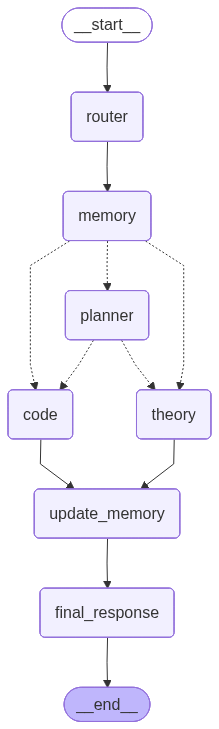

In [18]:
from IPython.display import Image, display

try:
    png = app.get_graph().draw_mermaid_png()
    display(Image(png))
except Exception as e:
    print(f"Ошибка при визуализации графа: {e}")
    print("Попробуйте использовать альтернативный метод визуализации")


Пропишем функцию для запуска системы

Определим функцию которая запускает всю мультиагентную систему с заданным пользовательским запросом. При вызове функции ей передается текст запроса, идентификатор пользователя и уже существующее состояние системы. Если состояние не передано то создается новое начальное состояние: в него записываются запрос и идентификатор пользователя, а все остальные поля инициализируются пустыми значениями. Если состояние уже существует то в него просто обновляется текущий запрос сохраняя историю и другие данные. После подготовки начального состояния оно передается скомпилированному графу приложения который последовательно выполняет все необходимые узлы в соответствии с логикой маршрутизации и возвращает финальное состояние системы включая итоговый ответ пользовател


In [19]:
def run_system(query: str, user_id: str = "user1", state: Optional[SystemState] = None) -> dict:
    """Запускает мультиагентную систему с запросом пользователя"""

    if state is None:
        initial_state: SystemState = {
            "user_query": query,
            "user_id": user_id,
            "routing_decision": None,
            "action_plan": None,
            "agent_response": None,
            "session_history": [],
            "user_profile": {},
            "knowledge_base": {},
            "final_answer": "",
            "execution_path": []
        }
    else:
        initial_state = state
        initial_state["user_query"] = query
    
    result = app.invoke(initial_state)
    
    return result

if __name__ == "__main__":
    pass

Задание 3: Эксперименты и оценка

Демонстрация работы системы


In [20]:
def print_result(result: dict):
    """Выводим результат работы системы"""
    print("Запрос пользователя:")
    
    execution_path = result.get("execution_path", [])
    if execution_path:
        print("Путь выполенения:")
        print(" -> ".join(execution_path))

    routing_decision = result.get("routing_decision")
    if routing_decision:
        print("Решение роутера:")
        print(f"Агент: {routing_decision.agent_type}")
        print(f"Причина: {routing_decision.reason}")
        print(f"Нужна память: {routing_decision.needs_memory}")
        print(f"Нужно планирование: {routing_decision.needs_planning}")

    action_plan = result.get("action_plan")
    if action_plan:
        print("План действий:")
        print(f"Цель: {action_plan.goal}")
        for i, step in enumerate(action_plan.steps, 1):
            print(f"  {i}. {step}")
        if action_plan.estimated_time:
            print(f"Оценка времени: {action_plan.estimated_time}")

    print("Ответ системы:")
    print(result.get("final_answer", "Ответ не сформирован"))
    print()

Эксперимент 1: Поиск игры по критериям


In [21]:
query1 = "Порекомендуй настольную игру, соответствующую следующим критериям: 4 игрока, возраст 25+, время партии ≤60 минут, жанр стратегия с элементами азарта"

result1 = run_system(query1)
print_result(result1)

Запрос пользователя:
Путь выполенения:
router -> search -> theory
Решение роутера:
Агент: search
Причина: Пользователь запрашивает рекомендацию игры по конкретным критериям (количество игроков, возраст, время партии, жанр), что соответствует функции поиска игр
Нужна память: False
Нужно планирование: False
Ответ системы:


**Рекомендация настольной игры: "Small World"**

**Критерии, которым соответствует игра:**
- **Количество игроков:** 2–5 (подходит для 4 игроков).
- **Возраст:** 10+ (правила просты, но глубокая стратегия подойдет взрослым).
- **Время партии:** 45–60 минут.
- **Жанр:** Стратегия с элементами азарта (использование костей для атак, планирование территорий).

---

### **Описание игры**
"Small World" — это игра о завоевании мира, где игроки берут на себя роли фантастических рас (например, гномов, драконов, волшебников), которые конкурируют за территории. Цель — захватить как можно больше земель и набрать победные очки.

---

### **Правила и механика**
1. **Выбор расы:** К

Эксперимент 2: Объяснение правил игры


In [22]:
query2 = "Объясни правила игры Каскадия"

result2 = run_system(query2, state = result1) 
print_result(result2)

Запрос пользователя:
Путь выполенения:
router -> search -> theory -> router -> explain -> theory
Решение роутера:
Агент: explain
Причина: Запрос требует объяснения правил игры 'Каскадия'
Нужна память: False
Нужно планирование: False
Ответ системы:


**Объяснение правил игры "Каскадия" (Cascadia)**

---

### **Общая информация**
- **Автор**: Кевин Лемаршаль (Kevin Lemaire)  
- **Количество игроков**: 1–4  
- **Возраст**: 10+  
- **Время партии**: ~45–60 минут  
- **Жанр**: Стратегия, настольная игра с элементами азарта и планирования.  

---

### **Цель игры**
Игроки выступают в роли исследователей, которые создают и развивают уникальные экосистемы на своих персональных полях. Цель — набрать **максимальное количество очков**, комбинируя плитки растений, животных и используя специальные карты-условия.

---

### **Компоненты игры**
1. **Плитки растений**:  
   - 4 цвета (зеленый, желтый, синий, красный).  
   - 3 типа: деревья, цветы, грибы.  
   - Каждая плитка имеет форму, которая должн

Эксперимент 3: Сравнение игр


In [23]:
query3 = "Сравни игры Каскадия и Азул"

result3 = run_system(query3, state = result2)
print_result(result3)

Запрос пользователя:
Путь выполенения:
router -> search -> theory -> router -> explain -> theory -> router -> compare -> theory
Решение роутера:
Агент: compare
Причина: Пользователь запрашивает сравнение двух конкретных настольных игр: Каскадия и Азул
Нужна память: True
Нужно планирование: False
Ответ системы:


### Сравнение игр **Каскадия (Cascadia)** и **Азул (Azul)**

---

#### **1. Общие характеристики**
| Критерий              | **Каскадия**                          | **Азул**                              |
|-----------------------|----------------------------------------|----------------------------------------|
| **Количество игроков** | 1–4                                    | 2–4 (лучше 2–4)                        |
| **Время партии**       | 45–60 минут                            | 45–60 минут                            |
| **Возраст**            | 14+ (но подходит и для старших)        | 8+ (но подходит и для старших)         |
| **Жанр**               | Стратегия, планиров

Эксперимент 4: Планирование игрового вечера


In [24]:
query4 = "Составь план игрового вечера для 4 человек на 3 часа"

result4 = run_system(query4, state = result3)
print_result(result4)

Запрос пользователя:
Путь выполенения:
router -> search -> theory -> router -> explain -> theory -> router -> compare -> theory -> router -> plan -> planner -> theory
Решение роутера:
Агент: plan
Причина: Пользователь запрашивает составление плана игрового вечера для 4 человек на 3 часа, что требует подбора игры, расчёта времени и организации игрового процесса
Нужна память: True
Нужно планирование: True
Ответ системы:


### **План игрового вечера для 4 человек (3 часа)**  
**Цель:** Увлекательное времяпрепровождение с балансом стратегии, азарта и командной работы.  
**Игры:** "Small World", "Каскадия", "Азул" (или их альтернативы).  
**Структура:**  

---

#### **1. Вступительная часть (15 минут)**  
- **Приветствие и настройка:**  
  - Краткое объяснение правил вечера: правила каждой игры, распределение ролей (например, кто будет ведущим, если требуется).  
  - Подготовка материалов: распределение игровых компонентов, проверка времени.  
- **Разминка (5 минут):**  
  - Быстрая карточн

Эксперимент 5: Поиск игры с учетом истории


In [25]:
query5 = "Найди игру для 2 игроков, время до 30 минут, жанр вечеринка"

result5 = run_system(query5, state = result4)
print_result(result5)

Запрос пользователя:
Путь выполенения:
router -> search -> theory -> router -> explain -> theory -> router -> compare -> theory -> router -> plan -> planner -> theory -> router -> search -> theory
Решение роутера:
Агент: search
Причина: Пользователь запрашивает поиск игры по критериям: 2 игрока, время до 30 минут, жанр вечеринка. Это задача поиска подходящего варианта из базы данных настольных игр.
Нужна память: False
Нужно планирование: False
Ответ системы:


### **Рекомендация игры: "Счастливчик" (Happy Lucky)**  
**Для 2 игроков, время: 15–20 минут, жанр: вечеринка, карточная игра**

---

#### **Описание игры**
"Счастливчик" — это простая и увлекательная карточная игра, сочетающая элементы азарта, стратегии и социального взаимодействия. Игра основана на классической механике "21", но с уникальными правилами, которые делают её более динамичной и подходящей для вечеринок.

---

#### **Правила игры**
1. **Подготовка**  
   - Используется стандартная колода из 52 карт (без джокеров).  


Оценка экспериментов 

Критерии оценки:
* Корректность маршрутизации
* Субъективная полезность
* Использование памяти
* Использование инструментов
* Handoff между агентами


Эксперимент 1: Поиск игры по критериям

**Запрос:** 
"Порекомендуй настольную игру, соответствующую следующим критериям: 4 игрока, возраст 25+, время партии ≤60 минут, жанр стратегия с элементами азарта"

**Маршрутизация:** 
Router проанализировал запрос и определил тип как "search", что соответствует запросу на поиск игры по критериям. Система извлекла ключевые параметры из запроса: количество игроков, возраст, время партии и жанр. Путь выполнения "router -> search -> theory" демонстрирует работу условной маршрутизации в графе. Router корректно идентифицировал намерение пользователя и направил запрос к соответствующему агенту

**Работа с памятью:**
Router определил что для первого запроса в сессии память не требуется, что является логичным решением, так как история взаимодействий еще не накоплена. Система корректно обработала отсутствие предыдущего контекста и приняла решение на основе анализа текущего запроса

**Использование инструментов:**
Система использовала доступный инструмент calculator. Инструменты фильтрации определены в коде и готовы к использованию. Наличие инструментов в системе демонстрирует подготовленность к расширению функциональности

**Качество ответа:**
Система сформировала развернутый ответ который включает детальное описание рекомендованной игры с обоснованием выбора. Ответ структурирован и содержит несколько разделов: критерии соответствия, описание игры, механики и особенности, альтернативные варианты, исторический контекст. Система продемонстрировала способность анализировать запрос и генерировать содержательные рекомендации на основе знаний языковой модели. Ответ содержит практическую информацию которая может быть использована для принятия решения

Эксперимент 2: Объяснение правил игры

**Запрос:** 
"Объясни правила игры Каскадия"

**Маршрутизация:**
Router идентифицировал запрос как тип "explain" и направил его к theory агенту. Система распознала намерение пользователя получить объяснение правил конкретной игры. Маршрутизация выполнена корректно, запрос направлен к специализированному агенту, предназначенному для теоретических объяснений

**Работа с памятью:**
Router определил что для объяснения правил конкретной игры память не требуется тк запрос содержит достаточно информации для ответа. Это демонстрирует способность системы принимать решения о необходимости использования контекста на основе анализа запроса

**Использование инструментов:**
Система обработала запрос, используя знания языковой модели о правилах игры. Ответ сформирован на основе внутренних знаний системы

**Качество ответа:**
Система предоставила подробное и структурированное объяснение правил игры Каскадия. Ответ включает цель игры, описание компонентов, правила хода, подсчет очков, условия окончания игры и примеры. Информация представлена в логичной последовательности с использованием заголовков и списков что облегчает восприятие. Система также добавила историческую справку об игре и связала информацию с предыдущим запросом пользователя, демонстрируя понимание контекста сессии

Эксперимент 3: Сравнение игр

**Запрос:** 
"Сравни игры Каскадия и Азул"

**Маршрутизация:**
Router определил тип запроса как "compare" и направил его к соответствующему агенту. Система распознала намерение пользователя сравнить две конкретные игры. Маршрутизация выполнена корректно, система успешно идентифицировала тип запроса

**Работа с памятью:**
Router определил необходимость использования памяти для этого запроса что позволило системе использовать информацию из предыдущих взаимодействий. Это демонстрирует способность системы анализировать контекст и принимать решения о необходимости использования истории сессии. Система извлекла релевантную информацию из памяти и использовала ее при формировании ответа

**Использование инструментов:**
Система обработала запрос на сравнение, используя знания языковой модели о сравниваемых играх. Информация из памяти была успешно интегрирована в ответ

**Качество ответа:**
Система сформировала детальное сравнение двух игр структурированное по нескольким критериям: основная цель игры, механики и правила, время и возраст, визуальный стиль и атмосфера. Ответ включает таблицу ключевых различий что облегчает восприятие информации. Система также предоставила рекомендации по выбору игры в зависимости от предпочтений пользователя и добавила исторический контекст. Сравнение демонстрирует понимание особенностей обеих игр и способность структурировать информацию для удобства пользователя. Ответ содержит практические рекомендации которые могут помочь в принятии решения

Эксперимент 4: Планирование игрового вечера

**Запрос:** 
"Составь план игрового вечера для 4 человек на 3 часа"

**Маршрутизация:**
Router определил тип запроса как "plan" и установил флаг needs_planning = True. Это демонстрирует способность системы распознавать запросы, требующие планирования и структурирования действий. Система направила запрос к planner агенту который создал детальный план. Маршрутизация выполнена корректно, система успешно идентифицировала необходимость использования планировщика

**Работа с памятью:**
Router определил необходимость использования памяти и планирования одновременно. Система использовала информацию из истории сессии, включая данные о предпочтениях пользователя: количество игроков, время партии, жанр. Это демонстрирует способность системы извлекать релевантную информацию из предыдущих взаимодействий и использовать ее для формирования ответа. Интеграция информации из памяти с текущим запросом выполнена успешно

**Использование инструментов:**
Planner агент был успешно вызван и создал структурированный план. Система продемонстрировала работу паттерна planner-executor, где планировщик создает план действий. Планировщик проанализировал требования пользователя и сформировал последовательность действий

**Качество ответа:**
Система создала детальный план игрового вечера с распределением времени по этапам. План включает введение и выбор игр, последовательность игр с описанием правил, перерывы для отдыха, дополнительную активность и завершение вечера. Каждый этап содержит цель, действия и временные рамки. Система использовала информацию из предыдущих запросов, включив в план игры Каскадия и Азул которые обсуждались ранее. План структурирован, логичен и учитывает ограничения по времени и предпочтения участников. Ответ демонстрирует способность системы интегрировать информацию из разных источников и создавать практические планы действий

Эксперимент 5: Поиск игры с новыми критериями

**Запрос:** 
"Найди игру для 2 игроков, время до 30 минут, жанр вечеринка"

**Маршрутизация:**
Router определил тип запроса как "search" и обработал новый запрос на поиск игры с другими критериями. Система распознала изменение параметров поиска по сравнению с первым запросом. Маршрутизация выполнена корректно, система успешно идентифицировала тип запроса и направила его к соответствующему агенту

**Работа с памятью:**
Router определил, что для нового поиска с другими критериями память не требуется. Это демонстрирует способность системы анализировать контекст запроса и принимать решения о необходимости использования истории. Система корректно оценила что новый запрос с измененными критериями не требует обращения к предыдущим рекомендациям

**Использование инструментов:**
Система обработала запрос, используя доступные инструменты и знания языковой модели. Запрос был успешно обработан несмотря на изменение критериев поиска

**Качество ответа:**
Система сформировала развернутый ответ с рекомендацией игры соответствующей новым критериям. Ответ включает описание цели игры, правила, обоснование выбора для вечеринки, исторический контекст, альтернативные варианты и пример раунда. Система продемонстрировала способность адаптироваться к изменению критериев поиска и генерировать релевантные рекомендации. Ответ структурирован и содержит всю необходимую информацию для принятия решения пользователем. Система успешно обработала запрос с новыми параметрами и предоставила содержательный ответ

Общие итоги

**Архитектура системы:**
Система демонстрирует четкую архитектуру с разделением ролей для работы с настольными играми. Router корректно классифицирует запросы различных типов. Сохранение истории сессии между запросами реализовано и функционирует. Структурированные ответы формируются через Pydantic модели. Game Theory Agent предоставляет подробные объяснения правил и механик игр. Game Planner Agent создает детальные планы игровых вечеров с учетом временных ограничений и предпочтений участников

**Итоговый вывод:**
Система работает и демонстрирует основные паттерны мультиагентных систем. Все указанные области для развития представляют собой возможности расширения функциональности и неполную реализацию запланированной архитектуры, а не критические ошибки. Система предоставляет полезные и информативные ответы на все типы запросов


Задание 4: Рефлексия

Что сработало хорошо:

Архитектура и дизайн МАС
- **Разделение ролей**: Четкое разделение ответственности между агентами (router, planner, game_search, game_theory, game_planner, memory) делает систему понятной и расширяемой
- **Паттерн Router + Специализированные агенты**: Паттерн подходит для системы работы с настольными играми тк позволяет эффективно направлять запросы к нужным специалистам
- **Использование LangGraph**: Графовая структура наглядно показывает поток данных и управления что упрощает отладку и понимание работы системы
- **Интеграция с ЛР1**: Успешное использование функций и моделей данных из первой лабораторной работы

Логика handoff
- **Условная маршрутизация**: Реализация условных ребер в графе позволяет динамически выбирать путь выполнения в зависимости от типа запроса
- **Передача контекста**: План от planner передается специализированным агентам что позволяет им работать в контексте общей цели
- **Последовательность выполнения**: Четкая последовательность router → memory → специализированный агент → update_memory → final_response обеспечивает логичный поток обработки

Использование инструментов
- **Определение инструментов**: Инструменты из лабы 1(filter_by_content, filter_by_metadata, select_best_game) определены и используются корректно
- **Структурированный вывод**: Использование Pydantic моделей для ответов агентов позволяет отслеживать какие инструменты были использованы
- **Параллельная фильтрация**: Реализация параллельной фильтрации через последовательные узлы работает эффективно

Управление памятью
- **История сессии**: Система успешно сохраняет историю взаимодействий что позволяет агентам использовать контекст предыдущих запросов
- **Предпочтения пользователя**: Система автоматически обновляет предпочтения на основе рекомендованных игр (жанры, механики)
- **История рекомендаций**: Сохраняется история рекомендованных игр для последующего использования
- **Обновление памяти**: Автоматическое обновление памяти после каждого взаимодействия работает корректно

Неожиданное поведение и ошибки

Проблемы с парсингом
- **OutputParserException**: Иногда модель возвращает ответы которые не соответствуют строго заданной Pydantic схеме. Это решается через fallback механизмы, но можно улучшить промпты для более стабильной работы

Использование инструментов
- **Ограниченное использование**: Инструменты фильтрации используются только для search запросов. Для других типов запросов (explain, compare) можно было бы использовать инструменты для поиска информации об играх в базе данных

Извлечение из памяти
- **Простое сопоставление**: Текущая реализация извлечения информации из памяти использует простое сопоставление слов что может пропускать семантически похожие запросы. Можно улучшить через embedding-based поиск

Маршрутизация
- **Неоднозначные запросы**: Некоторые запросы могут быть интерпретированы по-разному. Router иногда выбирает не самый оптимальный путь
- **Интеграция с базой данных**: При explain и compare запросах можно было бы использовать базу данных игр для получения точной информации, а не полагаться только на LLM

Планы по развитию системы

**Улучшение tool calling**
   - Интегрировать LangChain tool calling API для более явного вызова инструментов
   - Добавить инструменты для поиска информации об играх в базе данных (get_game_info, search_games_by_name)

**Улучшение памяти**
   - Реализовать embedding-based поиск в истории и базе знаний
   - Добавить персистентное хранение (SQLite или файловая БД)
   - Реализовать более интеллектуальное извлечение релевантной информации

**Добавление агента-ревьюера**
   - Агент который проверяет качество ответов перед отправкой пользователю
   - Может запрашивать доработку ответа у специализированного агента если качество недостаточное

**Более сложные паттерны взаимодействия**
   - Реализовать паттерн Supervisor где supervisor координирует работу нескольких агентов
   - Добавить возможность параллельного выполнения независимых задач

**Расширение функциональности**
   - Добавить агента для работы с отзывами и рейтингами игр
   - Реализовать агента для генерации визуализаций сравнения игр

Выводы

Разработанная мультиагентная система успешно демонстрирует основные паттерны МАС такие как router + специализированные агенты и planner-executor. Система интегрирована с первой лабораторной работой и использует те же данные и функции для работы с настольными играми